In [21]:
import pandas as pd

# load die CSV-Datei
data = pd.read_csv('../data/raw_data.csv')

In [22]:
data['text'] = data['text'].astype('string')
data['title'] = data['title'].astype('string')
data['label'] = data['label'].astype('bool')

# Check Data

## combine title and text, and delete title

In [23]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [24]:
## Cleaning 2: combine the text and the title
## Cleaning 1: filling the missing data with spaces
data = data.fillna(' ') ## aplying to na via fillna

## Cleaning 2: combine the text and the title
data['text'] = data['title'] + data['text']

## delete title column
data.drop('title',axis=1,inplace=True)

In [25]:
print(f"data.shape: {data.shape}")

data.shape: (72134, 2)


In [26]:
# Calculation of the distribution in per cent
label_counts = data['label'].value_counts(normalize=True) * 100
# Formatted output
print(f"Balancing result is label 0: {label_counts.get(0, 0):.2f}%, label 1: {label_counts.get(1, 0):.2f}%")

Balancing result is label 0: 51.44%, label 1: 48.56%


## check nulls

In [27]:
# Calculate percentage of NaN values in each column
nan_percentage = (data.isna().sum() / len(data)) * 100

# Format output with percentage symbol
formatted_nan_percentage = nan_percentage.apply(lambda x: f"{x:.2f}%")

# Print each column's NaN percentage
for col, percentage in formatted_nan_percentage.items():
    print(f"{col}: {percentage}")

text: 0.00%
label: 0.00%


In [28]:
data.shape

(72134, 2)

## delete duplicated raws

In [29]:
data.drop_duplicates(inplace=True)

# Baseline


## Data cleaning: strip, lower, digit, punctuation

In [30]:
import re
import string

def basic_cleaning(texte):
    # stripping:
    data['text'] = data['text'].str.strip()

    # tolower:
    data['text'] = data['text'].str.lower()

    # digit: Remove digits from each row of the ‘text’ column
    data['text'] = data['text'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

    # punctuation: Remove all punctuation marks from the ‘text’ column
    data['text'] = data['text'].str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)

    # delete html-tags
    data['text'] = data['text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

    return data['text']

In [31]:
import time
s = time.time()
data['text'] = basic_cleaning(data['text'])
time_to_clean = time.time() - s
print('Time to basic clean {:.2f} s'.format(time_to_clean))

Time to basic clean 16.63 s


In [32]:
data.head()

,text,label
0,law enforcement on high alert following threat...,True
1,did they post their votes for hillary already,True
2,unbelievable obama’s attorney general says mos...,True
3,bobby jindal raised hindu uses story of christ...,False
4,satan russia unvelis an image of its terrifyi...,True


##  Naive Bayes model (MultinomialNB)

In [33]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

In [34]:
X = data['text']
y = data['label']
X.info()

<class 'pandas.core.series.Series'>
Int64Index: 63678 entries, 11705 to 62874
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
63678 non-null  object
dtypes: object(1)
memory usage: 995.0+ KB


In [35]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Create tokenization and modelling pipeline
# MultinomialNB: Naive Bayes is a probabilistic classification model based on Bayes' theorem.
# It is particularly effective for text classification tasks
model_NB = Pipeline([
                    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf",MultinomialNB())])    # model the text

# Fit the pipeline to the training data
model_NB = model_NB.fit(X_train, y_train)

In [36]:
# Access the model and the vectorizer after fitting
# 1. Access the Naive Bayes model (MultinomialNB)
clf = model_NB.named_steps["clf"]
print("Logarithmized class probabilities (class_log_prior_):")
print(clf.class_log_prior_)  # Shows the log-probabilities of each class
print("\nLogarithmized feature probabilities (feature_log_prob_):")
print(clf.feature_log_prob_)  # Shows the probabilities per feature (word)

# 2. Access the TfidfVectorizer
vectorizer = model_NB.named_steps["tfidf"]
print("\nFeatures (words) in the vocabulary of the TfidfVectorizer:")
print(vectorizer.get_feature_names_out())  # Lists all words in the vocabulary


Logarithmized class probabilities (class_log_prior_):
[-0.60297752 -0.79226052]

Logarithmized feature probabilities (feature_log_prob_):
[[-12.66473257 -12.67030353 -13.26003166 ... -13.26003166 -13.26003166
  -13.26003166]
 [-11.88998883 -12.6550621  -13.11073621 ... -13.0881991  -13.07707675
  -13.11528578]]

Features (words) in the vocabulary of the TfidfVectorizer:
['aa' 'aaa' 'aaaa' ... '预防和解决冲突' '선녀' 'ｓꮭ']


In [37]:
test_score = model_NB.score(X_test,y_test) # calculates the accuracy of the model on the test set
test_score

0.8195665829145728

In [38]:
y_pred = model_NB.predict(X_test)

In [39]:
from sklearn.metrics import classification_report
# Ausgabe der Klassifikationsmetrik
print("\nKlassifikationsbericht auf Testdaten:")
print(classification_report(y_test, y_pred))



Klassifikationsbericht auf Testdaten:
              precision    recall  f1-score   support

       False       0.76      0.97      0.85     10401
        True       0.95      0.64      0.76      8703

    accuracy                           0.82     19104
   macro avg       0.85      0.80      0.81     19104
weighted avg       0.85      0.82      0.81     19104



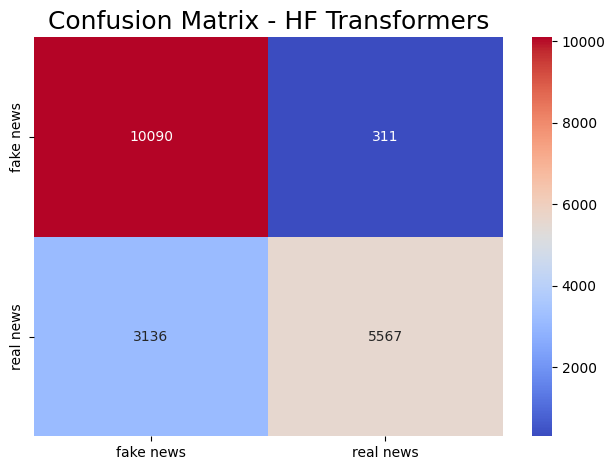

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [41]:
import pickle

# Save the trained model to a file
with open('model_NB.pkl', 'wb') as file:
    pickle.dump(model_NB, file)

print("Model saved successfully.")


Model saved successfully.


In [44]:
import joblib
import os

timestamp = time.strftime("%Y%m%d-%H%M%S")
# Save model locally
local_reg_path = os.path.join(os.getcwd(), "local_registry")
model_path = os.path.join(f"{timestamp}.h5")
joblib.dump(model_NB, model_path)

['20241218-155952.h5']

In [ ]:
os.path.join(os.path.expanduser('~'), "code", "namrata1104", "Fake_news_detection", "training_outputs")